# Classifying 3x3 mazes - Using symmetry
In this notebook we use the same Quantum Machine Learing approach as for the Tic-Tac-Toe boards, but for a different application: determining whether a path exists between any two corners of a 3x3 maze. The following cells show some examples, where the mazes are colored green or red depending on whether it is solvable or not, respectively.

In [1]:
from qiskit import *
import numpy as np
import maze as m

from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

def make_circuit(x, params, layers):
    circ = QuantumCircuit(9)
    for i in range(layers):
        l = i*9
        m.encode_data(x, circ)
        m.add_single_qubit_gates(params[l:l+6], circ)
        m.add_two_qubit_gates(params[l+6:l+9], circ)

    return circ
# Create a Quantum Circuit acting on a quantum register of nine qubits

layers = 4

params = np.random.rand(9*layers)*2*np.pi
circ = make_circuit([1,1,0,0,0,1,0,0,0], params, layers)

maze_fields, grid_combinations = m.generate_maze_field()

In [2]:
# Define the loss function
def l2_loss(output, target):
    output, target = np.array(output), np.array(target)
    return np.abs(output - target)**2

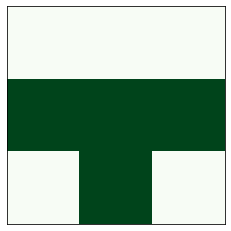

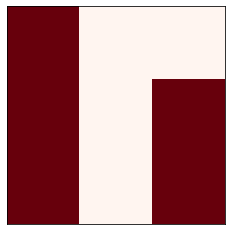

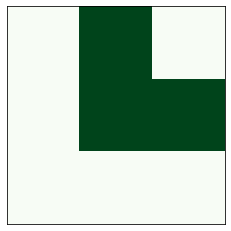

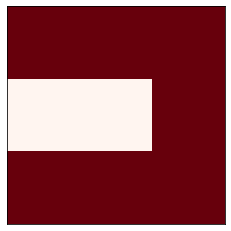

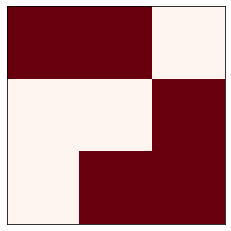

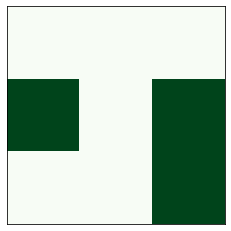

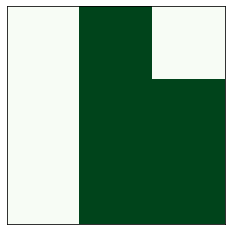

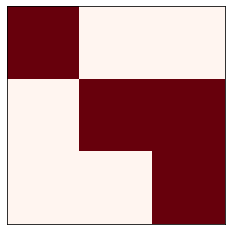

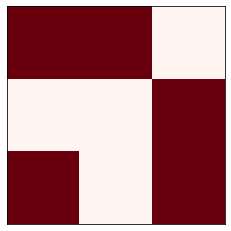

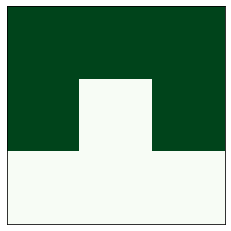

In [3]:
x = maze_fields
y = m.check(grid_combinations)
#print(x)
#print(y)

# shuffle the indices
shuffle_indices = np.random.permutation(len(x))
train_size = int(len(x) * 0.3)

# split the indices into training and testing sets
train_indices = np.array(shuffle_indices[:train_size])
test_indices = np.array(shuffle_indices[train_size:])

# create the training and testing sets
x_train, y_train = np.take(x, train_indices, axis=0), np.take(y, train_indices, axis=0)
x_test, y_test = np.take(x, test_indices, axis=0), np.take(y, test_indices, axis=0)

for maze in x[:10]:
    m.plot_maze(maze)

### Run the optimization

In [26]:
from tqdm import tqdm
# Define the optimizer
from qiskit.algorithms.optimizers import SPSA
optimizer = SPSA(maxiter = 100)

# Define the cost function to be minimized by the optimizer
def cost_function(params):

    cost = 0
    estimator = Estimator()
    observables = (
        SparsePauliOp("IIIIZIIII")
    )
    
    for x, y in zip(x_train, y_train):
        # Create a Quantum Circuit acting on a quantum register of nine qubits
        circ = make_circuit(x, params, layers)        

        circuits = (
            circ,
        )

        job = estimator.run(circuits, observables)
        result = job.result().values[0]
        
        prediction = (result + 1)/2
        
        cost += l2_loss(prediction, y)
        
    print(cost)
    return cost

# Initialize the parameters
params = np.random.rand(9*layers)*2*np.pi

# Train the circuit
print('Initial parameters:', params)

# Check the qiskit docs to figure out how to start an optimizer
result = optimizer.minimize(cost_function, x0 = params)
print("Finished optimization.")

Initial parameters: [0.34296901 1.95385271 2.8102811  5.55552378 0.3608153  5.26403483
 5.1111402  4.07962272 3.87902491 3.56692503 2.53257745 5.74691127
 2.47031956 5.67991957 1.6855731  0.95619582 5.76021781 0.64234735
 4.93230741 0.17513912 1.49837118 0.29435658 4.70677863 2.95358616
 5.70864426 5.66257257 6.07868691 0.03004654 2.79220784 5.41819084
 5.48884542 0.30596701 1.02637267 3.4312748  5.62684747 1.43435521]
31.92939298568108
35.5439000545166
34.64795935909542
34.54568304544559
34.07406037372596
31.79668726962846
35.15025033241819
33.59247925787289
35.8659562700329
34.123486497710644
36.222879965270934
32.35404286812431
34.13920596452887
34.89945644739013
32.78805599752238
34.08707109930814
33.473291718564475
35.064729155103514
34.121461572767494
34.94953459445588
32.729595537176614
34.36303472881345
33.89855805088808
35.46146485364949
31.645882185324368
33.44139970629763
34.910119100313686
35.094571464240076
34.71645700285829
34.60921376943678
31.9079226066283
35.5626510450

In [27]:
def predict(data, params):
    circ = make_circuit(data, params, layers)

    #TODO:  create observables and measure

    estimator = Estimator()
    observables = (
        SparsePauliOp("IIIIZIIII")
    )
    
    circuits = (
            circ
        )

    job = estimator.run(circuits, observables)
    result = job.result().values[0]
    
    

    return (result + 1)/2

In [28]:
def test_model(params, x_data, y_data):
    total_loss = 0
    correct_guesses = 0
    i = 0
    for x, y in zip(x_data, y_data):
        pred = predict(x, params)
        pred_discrete = round(pred)
        total_loss += l2_loss(pred, y)
        correct_guesses += np.all(pred_discrete == y)
        
        if i % 200 == 0 and False: 
            print("Correct output:", y)
            print("Actual output:", pred)
            print("Discrete_output:", pred_discrete)
            print("---------------")

    total_loss = total_loss / len(x_data)

    print("Correct guesses: {}/{} ({}%)".format(correct_guesses, len(x_data), round(correct_guesses/len(x_data)*100)))
    print("L2 Loss: {}".format(total_loss))
    
print("Train data:")
test_model(result.x, x_train, y_train)

print("Test data:")
test_model(result.x, x_test, y_test)

Train data:
Correct guesses: 105/132 (80%)
L2 Loss: 0.1964902326150473
Test data:
Correct guesses: 232/308 (75%)
L2 Loss: 0.19855525832542678
